In [ ]:
from google.colab import drive
# drive.mount('/content/drive', force_remount=True)
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
import os
#print(os.getcwd())
os.chdir('/content/drive/MyDrive/Colab Notebooks/projects/src')
#print(os.getcwd())


In [ ]:
import os
import os.path as osp

from tqdm import tqdm

import sklearn

import torch
import torchvision
# from torchinfo import summary

import torch.nn as nn
from torch.utils.data import DataLoader

from torchvision import datasets, transforms
import torchvision.models as models

import explain

import numpy as np
import scipy as sp
import scipy.ndimage as ndimage
import matplotlib.colors
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


## 모델 파라미터 (Parameter)

In [ ]:
# 모델에 입력할 Input 이미지의 크기를 지정함.
IMG_WIDTH = 256
IMG_HEIGHT = 256


# 데이터를 읽어올 경로를 지정함.
data_dir='/content/drive/MyDrive/Colab Notebooks/projects/dataset/'
# 학습된 모델이 저장된 경로를 지정함.
ckpt_dir = '/content/drive/MyDrive/Colab Notebooks/projects/model_weight/'

# 모델을 연산할 장비 설정 (Docker환경에서 작동할 수 있도록 CPU에서 계산함)
device = torch.device('cpu')

##*Visualization code*

In [ ]:
#modified from https://github.com/MisaOgura/flashtorch
import warnings

import matplotlib.pyplot as plt

import torch
import torch.nn as nn


class Backprop:
    """Provides an interface to perform backpropagation.
    This class provids a way to calculate the gradients of a target class
    output w.r.t. an input image, by performing a single backprobagation.
    The gradients obtained can be used to visualise an image-specific class
    saliency map, which can gives some intuition on regions within the input
    image that contribute the most (and least) to the corresponding output.
    More details on saliency maps: `Deep Inside Convolutional Networks:
    Visualising Image Classification Models and Saliency Maps
    <https://arxiv.org/pdf/1312.6034.pdf>`_.
    Args:
        model: A neural network model from `torchvision.models
            <https://pytorch.org/docs/stable/torchvision/models.html>`_.
    """ # noqa

    ####################
    # Public interface #
    ####################

    def __init__(self, model):
        self.model = model
        self.model.eval()
        self.gradients = None
        self._register_conv_hook()

    def calculate_gradients(self,
                            input_,
                            target_class=None,
                            take_max=False,
                            guided=False,
                            use_gpu=False):

        """Calculates gradients of the target_class output w.r.t. an input_.
        The gradients is calculated for each colour channel. Then, the maximum
        gradients across colour channels is returned.
        Args:
            input_ (torch.Tensor): With shape :math:`(N, C, H, W)`.
            target_class (int, optional, default=None)
            take_max (bool, optional, default=False): If True, take the maximum
                gradients across colour channels for each pixel.
            guided (bool, optional, default=Fakse): If True, perform guided
                backpropagation. See `Striving for Simplicity: The All
                Convolutional Net <https://arxiv.org/pdf/1412.6806.pdf>`_.
            use_gpu (bool, optional, default=False): Use GPU if set to True and
                `torch.cuda.is_available()`.
        Returns:
            gradients (torch.Tensor): With shape :math:`(C, H, W)`.
        """ # noqa

        if 'inception' in self.model.__class__.__name__.lower():
            if input_.size()[1:] != (3, 299, 299):
                raise ValueError('Image must be 299x299 for Inception models.')

        if guided:
            self.relu_outputs = []
            self._register_relu_hooks()

        if torch.cuda.is_available() and use_gpu:
            self.model = self.model.to('cuda')
            input_ = input_.to('cuda')

        self.model.zero_grad()

        self.gradients = torch.zeros(input_.shape)

        # Get a raw prediction value (logit) from the last linear layer

        output = self.model(input_)

        # Don't set the gradient target if the model is a binary classifier
        # i.e. has one class prediction

        if len(output.shape) == 1:
            target = None
        else:
            _, top_class = output.topk(1, dim=1)

            # Create a 2D tensor with shape (1, num_classes) and
            # set all element to zero

            target = torch.FloatTensor(1, output.shape[-1]).zero_()

            if torch.cuda.is_available() and use_gpu:
                target = target.to('cuda')

            if (target_class is not None) and (top_class != target_class):
                warnings.warn(UserWarning('WRONG prediction! but calculating the gradient w.r.t. the target class '
                    # f'The predicted class index {top_class.item()} does not' +
                    # f'equal the target class index {target_class}. ' +
                    # 'Calculating the gradient w.r.t. the predicted class.'
                ))
            # print('target_class: ' + str(target_class))
            # print('top_class: ' + str(top_class))
            # print(top_class == target_class)
            # print(target_class is not None)

            # Set the element at top class index to be 1

            target[0][target_class] = 1

        # Calculate gradients of the target class output w.r.t. input_

        output.backward(gradient=target)

        # Detach the gradients from the graph and move to cpu

        gradients = self.gradients.detach().cpu()[0]

        if take_max:
            # Take the maximum across colour channels

            gradients = gradients.max(dim=0, keepdim=True)[0]

        return gradients

    def visualize(self, input_, target_class, guided=False, use_gpu=False,
                  figsize=(16, 4), cmap='viridis', alpha=.5,
                  #figsize=(12, 4), cmap='viridis', alpha=.5,
                  return_output=False):
        """Calculates gradients and visualizes the output.
        A method that combines the backprop operation and visualization.
        It also returns the gradients, if specified with `return_output=True`.
        Args:
            input_ (torch.Tensor): With shape :math:`(N, C, H, W)`.
            target_class (int, optional, default=None)
            take_max (bool, optional, default=False): If True, take the maximum
                gradients across colour channels for each pixel.
            guided (bool, optional, default=Fakse): If True, perform guided
                backpropagation. See `Striving for Simplicity: The All
                Convolutional Net <https://arxiv.org/pdf/1412.6806.pdf>`_.
            use_gpu (bool, optional, default=False): Use GPU if set to True and
                `torch.cuda.is_available()`.
            figsize (tuple, optional, default=(16, 4)): The size of the plot.
            cmap (str, optional, default='viridis): The color map of the
                gradients plots. See avaialable color maps `here <https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html>`_.
            alpha (float, optional, default=.5): The alpha value of the max
                gradients to be jaxaposed on top of the input image.
            return_output (bool, optional, default=False): Returns the
                output(s) of optimization if set to True.
        Returns:
            gradients (torch.Tensor): With shape :math:`(C, H, W)`.
        """ # noqa

        # Calculate gradients

        gradients = self.calculate_gradients(input_,
                                             target_class,
                                             guided=guided,
                                             use_gpu=use_gpu)
        max_gradients = self.calculate_gradients(input_,
                                                 target_class,
                                                 guided=guided,
                                                 take_max=True,
                                                 use_gpu=use_gpu)

        # Setup subplots
        subplots = [
            # (title, [(image1, cmap, alpha), (image2, cmap, alpha)])
            ('Input image',
             [(format_for_plotting((input_)), None, None)]),
            ('Gradients across RGB channels',
             [(format_for_plotting(standardize_and_clip(gradients)),
              None,
              None)]),
            ('Max gradients',
             [(format_for_plotting(standardize_and_clip(max_gradients)),
              cmap,
              None)]),
            ('Overlay',
             [(format_for_plotting((input_)), None, None),
              (format_for_plotting(standardize_and_clip(max_gradients)),
               cmap,
               alpha)])
        ]

        fig = plt.figure(figsize=figsize)

        for i, (title, images) in enumerate(subplots):
            ax = fig.add_subplot(1, len(subplots), i + 1)
            ax.set_axis_off()
            ax.set_title(title, color = 'white')
            for image, cmap, alpha in images:
                im = ax.imshow(image, cmap=cmap, alpha=alpha)

        if return_output:
            return gradients, max_gradients

    #####################
    # Private interface #
    #####################

    def _register_conv_hook(self):
        def _record_gradients(module, grad_in, grad_out):
            if self.gradients.shape == grad_in[0].shape:
                self.gradients = grad_in[0]

        for _, module in self.model.named_modules():
            if isinstance(module, nn.modules.conv.Conv2d):
                module.register_backward_hook(_record_gradients)
                break

    def _register_relu_hooks(self):
        def _record_output(module, input_, output):
            self.relu_outputs.append(output)

        def _clip_gradients(module, grad_in, grad_out):
            relu_output = self.relu_outputs.pop()
            clippled_grad_out = grad_out[0].clamp(0.0)

            return (clippled_grad_out.mul(relu_output),)

        for _, module in self.model.named_modules():
            if isinstance(module, nn.ReLU):
                module.register_forward_hook(_record_output)
                module.register_backward_hook(_clip_gradients)


#!/usr/bin/env python
"""flashtorch.utils
This module provides utility functions for image handling and tensor
transformation.
"""
from PIL import Image

import torchvision.transforms as transforms
import torchvision.transforms.functional as F

# from .imagenet import * # noqa


def load_image(image_path):
    """Loads image as a PIL RGB image.
    Args:
        image_path (str): A path to the image
    Returns:
        An instance of PIL.Image.Image in RGB
    """

    return Image.open(image_path).convert('RGB')


def standardize_and_clip(tensor, min_value=0.0, max_value=1.0,
                         saturation=0.1, brightness=0.5):

    """Standardizes and clips input tensor.
    Standardizes the input tensor (mean = 0.0, std = 1.0). The color saturation
    and brightness are adjusted, before tensor values are clipped to min/max
    (default: 0.0/1.0).
    Args:
        tensor (torch.Tensor):
        min_value (float, optional, default=0.0)
        max_value (float, optional, default=1.0)
        saturation (float, optional, default=0.1)
        brightness (float, optional, default=0.5)
    Shape:
        Input: :math:`(C, H, W)`
        Output: Same as the input
    Return:
        torch.Tensor (torch.float32): Normalised tensor with values between
            [min_value, max_value]
    """

    tensor = tensor.detach().cpu()

    mean = tensor.mean()
    std = tensor.std()

    if std == 0:
        std += 1e-7

    standardized = tensor.sub(mean).div(std)#.mul(saturation)
    #clipped = standardized.add(brightness).clamp(min_value, max_value)
    clipped = standardized.clamp(min_value, max_value)

    return clipped


def format_for_plotting(tensor):
    """Formats the shape of tensor for plotting.
    Tensors typically have a shape of :math:`(N, C, H, W)` or :math:`(C, H, W)`
    which is not suitable for plotting as images. This function formats an
    input tensor :math:`(H, W, C)` for RGB and :math:`(H, W)` for mono-channel
    data.
    Args:
        tensor (torch.Tensor, torch.float32): Image tensor
    Shape:
        Input: :math:`(N, C, H, W)` or :math:`(C, H, W)`
        Output: :math:`(H, W, C)` or :math:`(H, W)`, respectively
    Return:
        torch.Tensor (torch.float32): Formatted image tensor (detached)
    Note:
        Symbols used to describe dimensions:
            - N: number of images in a batch
            - C: number of channels
            - H: height of the image
            - W: width of the image
    """

    has_batch_dimension = len(tensor.shape) == 4
    formatted = tensor.clone()

    if has_batch_dimension:
        formatted = tensor.squeeze(0)

    if formatted.shape[0] == 1:
        return formatted.squeeze(0).detach()
    else:
        return formatted.permute(1, 2, 0).detach()

## 데이터 셋 (Dataset) 불러오기

In [ ]:
# 이미지 transformation
test_compose=transforms.Compose([
    transforms.Resize((IMG_HEIGHT,IMG_WIDTH)),
    transforms.ToTensor()
])




## CNN Visualization

### 2. 기본 모델을 Fine Tuning (학습) 한 모델 성능 평가 (Transfer Learning)

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

In [ ]:
# 모델 이름
Model_name_mobile = 'mobilenet_v3_small_trial_1_best_Acc'
Model_name2_res = 'resnext50_32x4d_trial1_best_Acc'
Model_name3_vgg = 'vgg19_trial_1_best_Acc'
Model_name_mobile_transfer = 'mobilenet_v3_small_transfer_best_Acc'
Model_names = [Model_name_mobile, Model_name2_res, Model_name3_vgg, Model_name_mobile_transfer]

# Model: ResNeXt50_32x4d
model_mobile=models.mobilenet_v3_small(pretrained=False)
model_res=models.resnext50_32x4d(pretrained=False)
model_vgg=models.vgg19(pretrained=False)
model_mobile_transfer=models.mobilenet_v3_small(pretrained=True)
models_trained = [model_mobile, model_res, model_vgg, model_mobile_transfer]

#Model_name = 'mobilenet_v3_small_trial_1_best_Acc'
#Model_name = 'resnext50_32x4d_trial1_best_Acc'
#Model_name = 'vgg19_trial_1_best_Acc'

# 최종 Label 의 개수 = 5 (1++, 1+, 1, 2, 3)
#for mobilenet
models_trained[0].classifier[0] = nn.Linear(in_features=models_trained[0].classifier[0].in_features, out_features=256)
models_trained[0].classifier[3] = nn.Linear(in_features=256, out_features=5)
#for resnext50
models_trained[1].fc=nn.Linear(models_trained[1].fc.in_features, 5) 
#for VGG
models_trained[2].classifier[-4]=nn.Linear(in_features=4096, out_features=256)
models_trained[2].classifier[-1]=nn.Linear(in_features=256, out_features=5)
#for mobilenet with predefined weights
models_trained[3].classifier[0] = nn.Linear(in_features=models_trained[3].classifier[0].in_features, out_features=256)
models_trained[3].classifier[3] = nn.Linear(in_features=256, out_features=5)

# 학습된 모델 가중치 불러오기
for i in range(len(Model_names)):
  checkpoint=torch.load(ckpt_dir + Model_names[i] + '.pth', map_location=device)
  models_trained[i].load_state_dict(checkpoint['state_dict'])

backprop_hanwoo = []
for i in range(len(models_trained)):
  backprop_hanwoo.append(Backprop(models_trained[i]))

['0', '1', '2', '3', '4']
/content/drive/MyDrive/Colab Notebooks/projects/dataset/val/0/[┐°├╡]╝╥╡╡├╝_seg_1_1024.jpeg
target class is 0
-------------------------------------
result of mobilenet_v3_small_trial_1_best_Acc: predicted 0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


-------------------------------------
result of resnext50_32x4d_trial1_best_Acc: predicted 0
-------------------------------------
result of vgg19_trial_1_best_Acc: predicted 0
-------------------------------------
result of mobilenet_v3_small_transfer_best_Acc: predicted 2
-------------------------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: UserWarning: WRONG prediction! but calculating the gradient w.r.t. the target class 


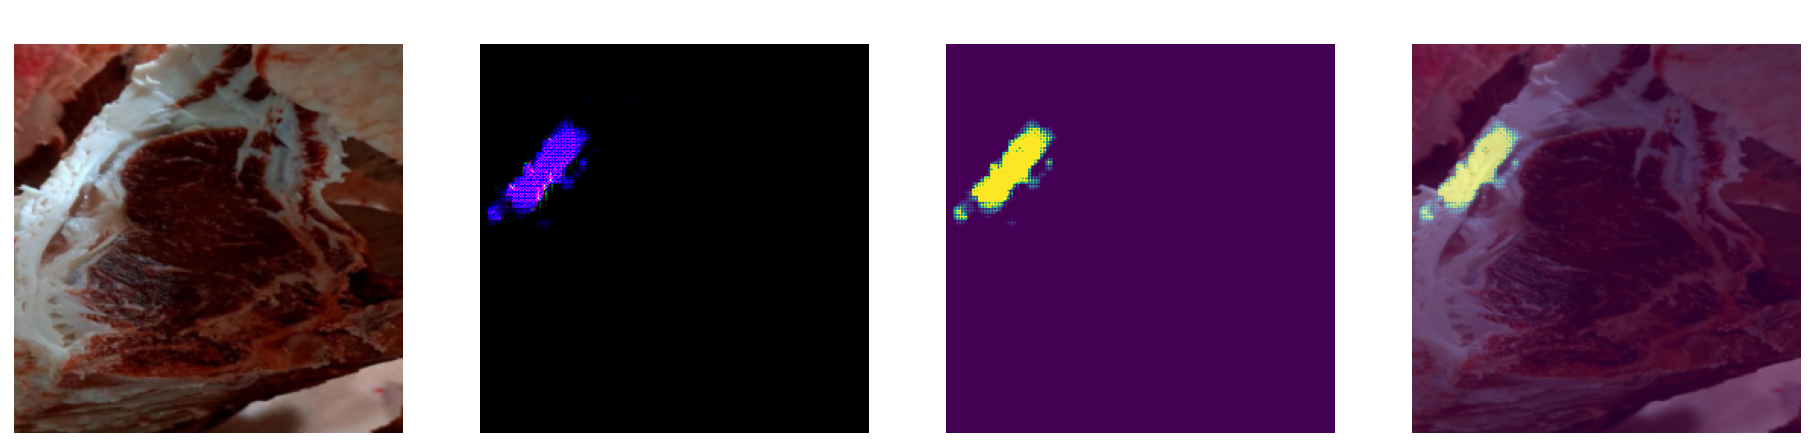

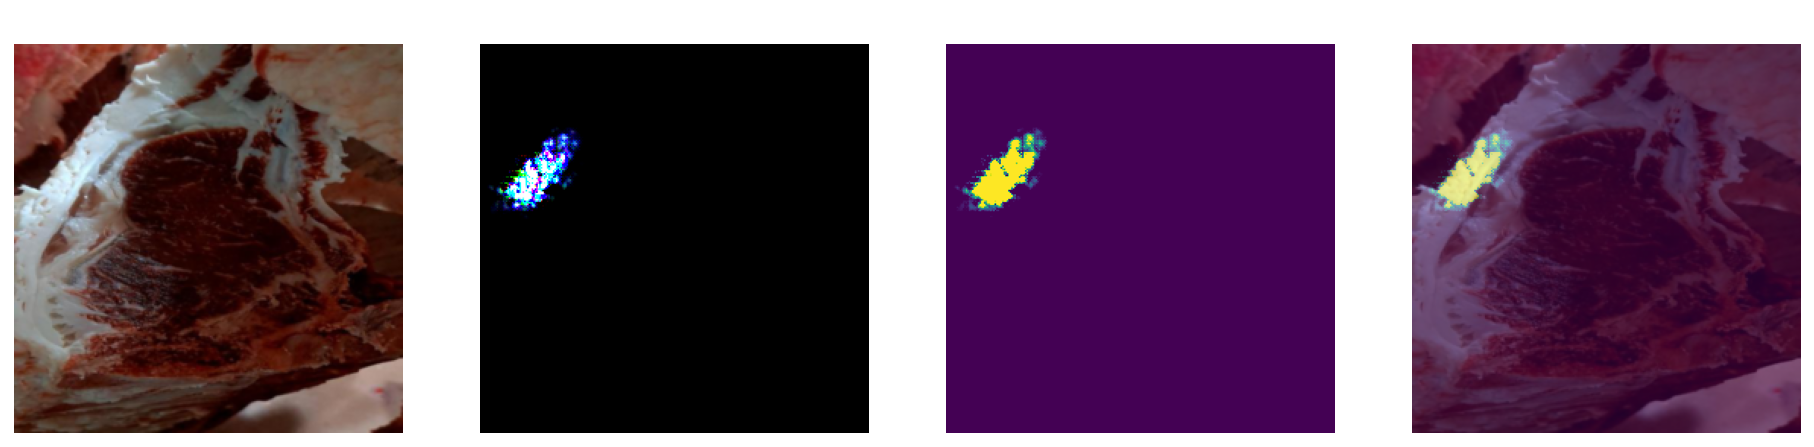

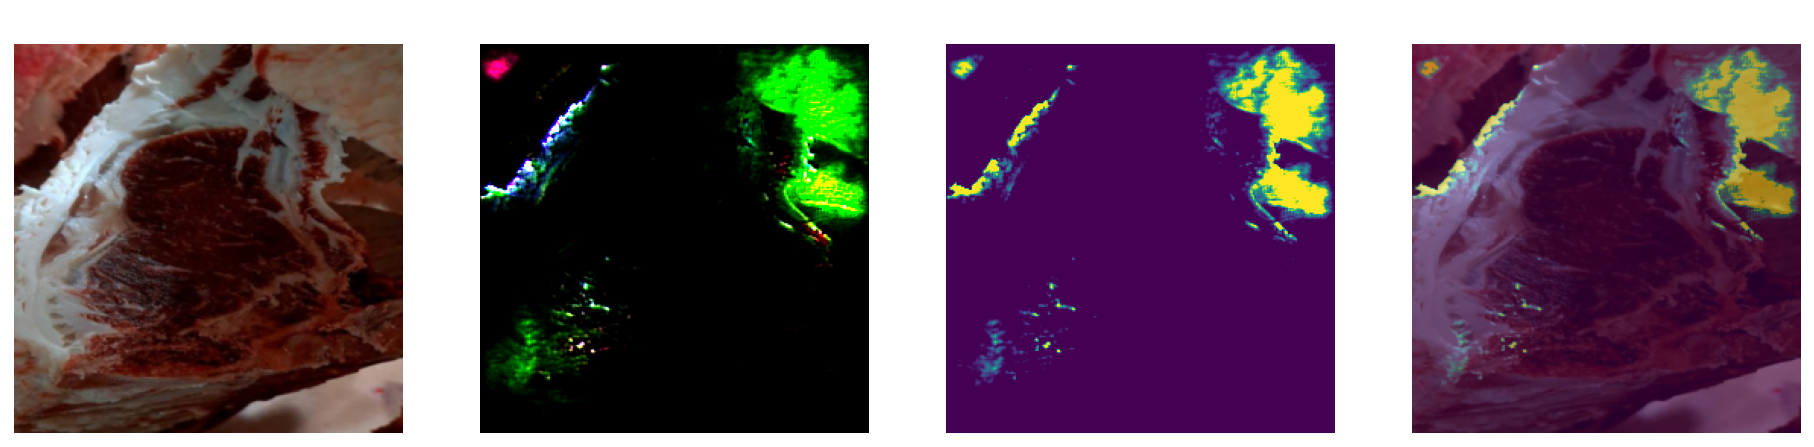

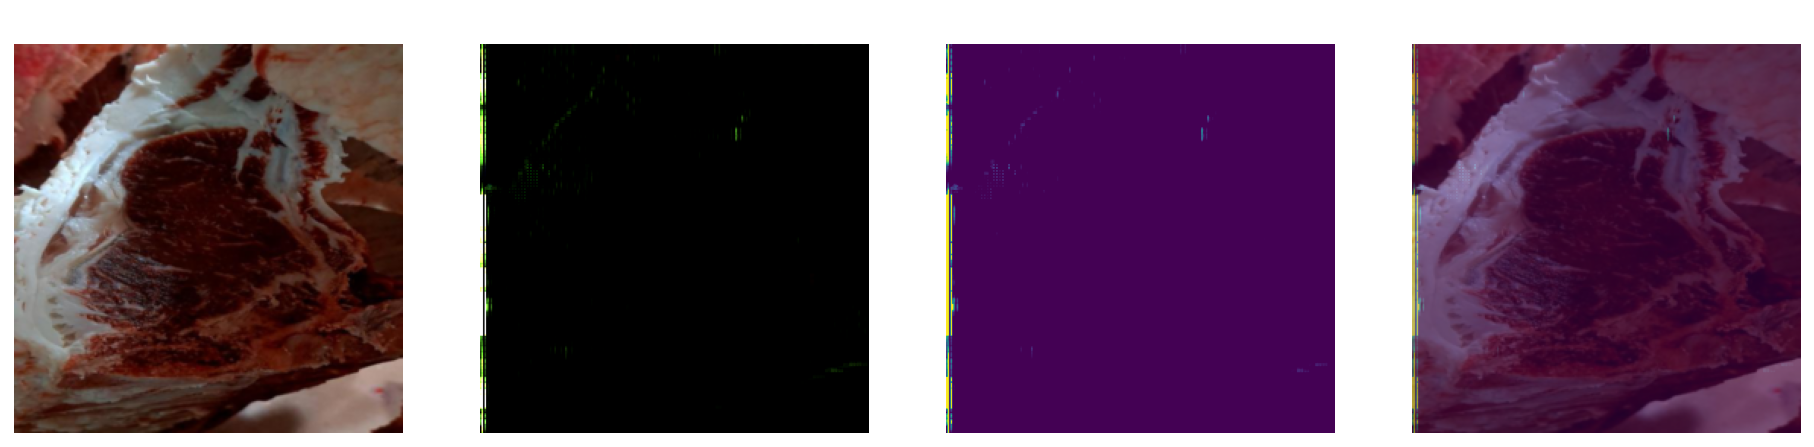

In [ ]:
# Set a target class number: 1++, 1+, 1, 2, 3
target_class = 0
class_folders = os.listdir('/content/drive/MyDrive/Colab Notebooks/projects/dataset/val/')
print(class_folders)
file_names = os.listdir('/content/drive/MyDrive/Colab Notebooks/projects/dataset/val/' + class_folders[target_class])

img_path = '/content/drive/MyDrive/Colab Notebooks/projects/dataset/val/' + class_folders[target_class] + '/' + file_names[119] #2:20, #1:9, #0: 419, #3:514, #4:12 ////#(0,119), (3,10)
print(img_path)
image = load_image(img_path)

# plt.imshow(image)
# plt.title('Original image')
# plt.axis('off')

# Transform the input image to a tensor
test_img = test_compose(image)
test_img = torch.unsqueeze(test_img, 0)

# Ready to roll!
print('=========================================')
print('target class is ' + str(target_class))
for i in range(len(backprop_hanwoo)):
  print('-------------------------------------')
  y = models_trained[i](test_img)
  print('result of ' + Model_names[i] + ': predicted ' + str(y.argmax())[-2])
  backprop_hanwoo[i].visualize(test_img.clone().detach().requires_grad_(True), target_class, guided=True, use_gpu=False)
print('-------------------------------------')

['0', '1', '2']
['1628853789052.jpg', 'test1++.JPG', '1++.jpg', '1++ 3.JPG', '1++ 33.png', '1++ 4444.JPG']
/content/drive/MyDrive/Colab Notebooks/projects/images/2/test1++.JPG
target class is 2
-------------------------------------
result of mobilenet_v3_small_trial_1_best_Acc: predicted 1


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: UserWarning: WRONG prediction! but calculating the gradient w.r.t. the target class 


-------------------------------------
result of resnext50_32x4d_trial1_best_Acc: predicted 1
-------------------------------------
result of vgg19_trial_1_best_Acc: predicted 4
-------------------------------------
result of mobilenet_v3_small_transfer_best_Acc: predicted 2
-------------------------------------


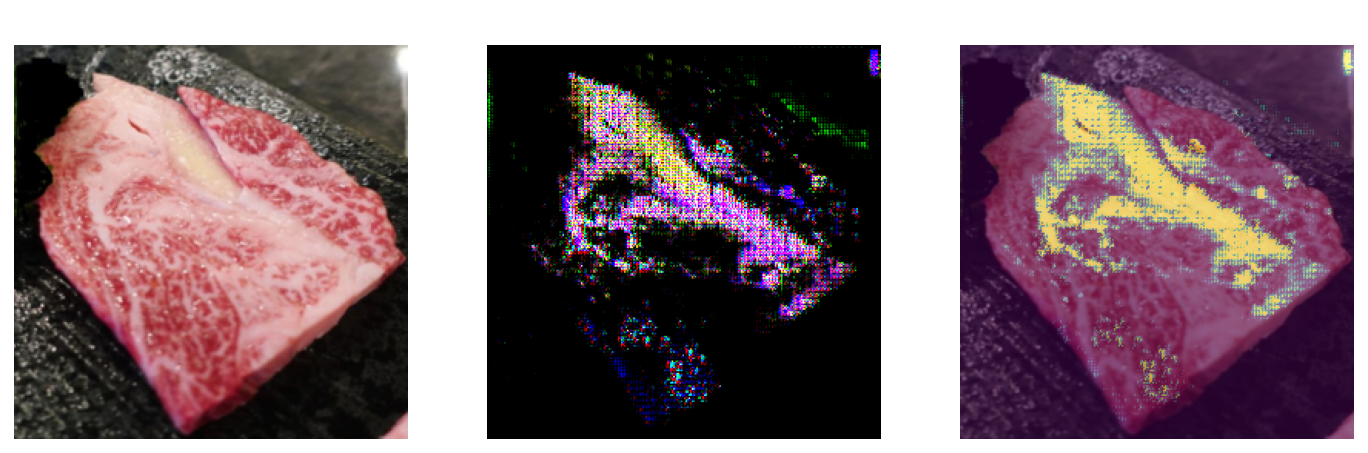

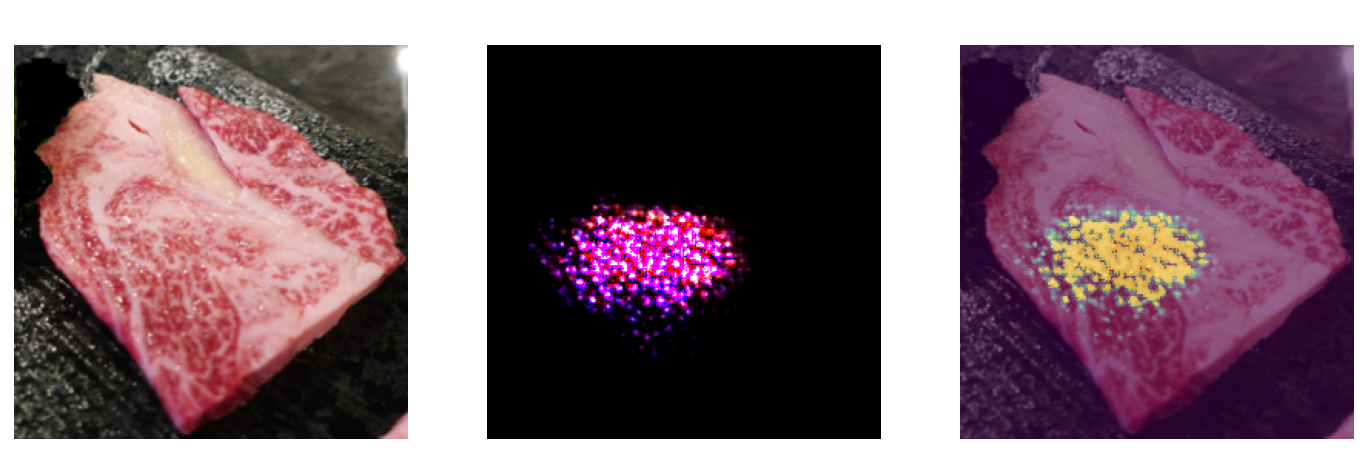

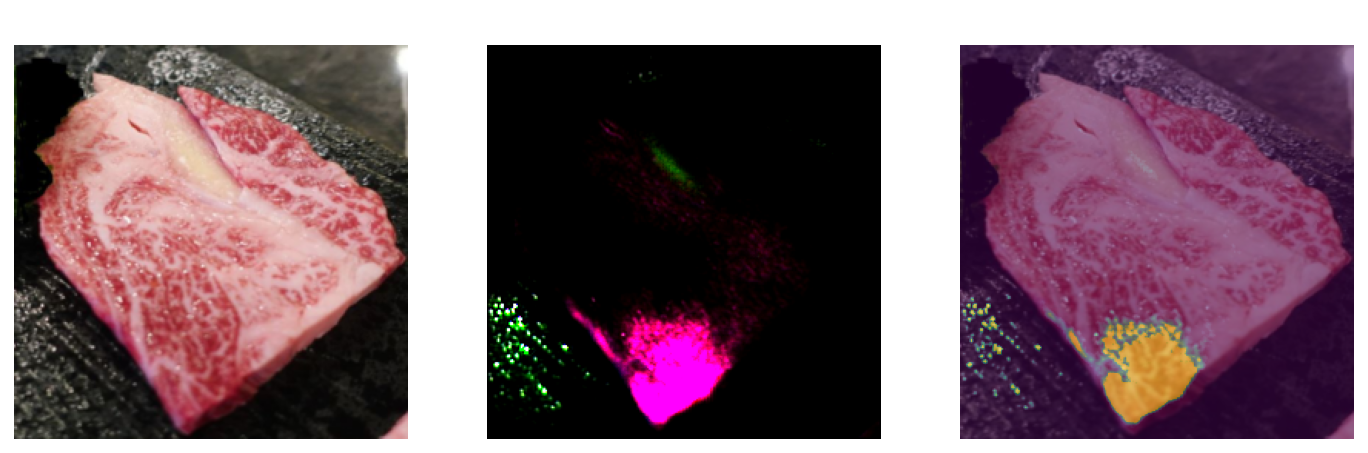

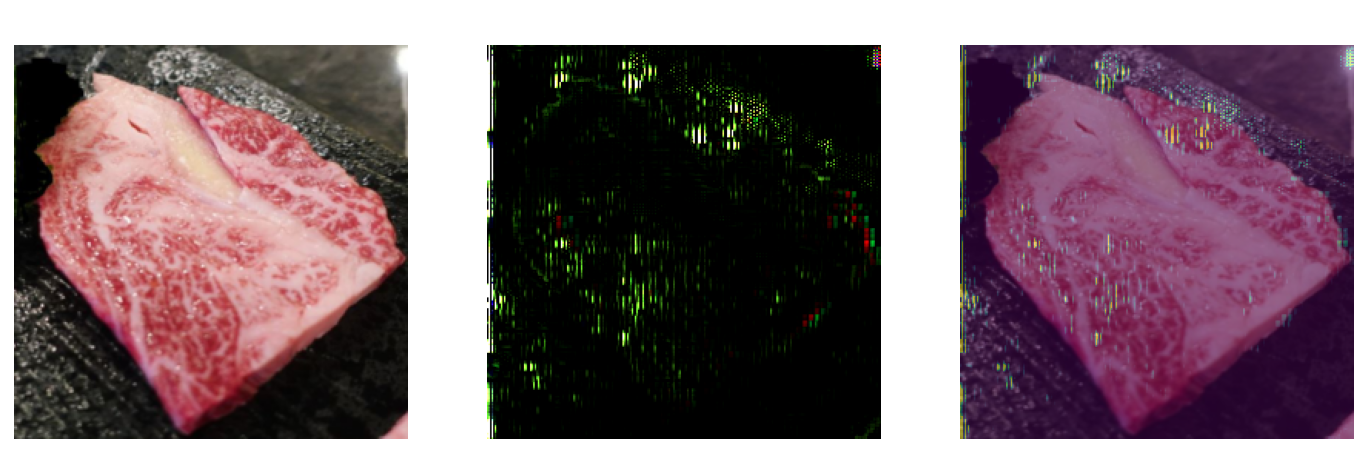

In [ ]:
# Set a target class number: 1++, 1+, 1, 2, 3
target_class = 2
root = '/content/drive/MyDrive/Colab Notebooks/projects/images/'
class_folders = sorted(os.listdir(root))
print(class_folders)
file_names = os.listdir(root + class_folders[target_class])
print(file_names)
img_path = root + class_folders[target_class] + '/' + file_names[1] #2:20, #1:9, #0: 419, #3:514, #4:12 ////#(0,119), (3,10)
print(img_path)
image = load_image(img_path)

# plt.imshow(image)
# plt.title('Original image')
# plt.axis('off')

# Transform the input image to a tensor
test_img = test_compose(image)
test_img = torch.unsqueeze(test_img, 0)

# Ready to roll!
print('=========================================')
print('target class is ' + str(target_class))
for i in range(len(backprop_hanwoo)):
  print('-------------------------------------')
  y = models_trained[i](test_img)
  print('result of ' + Model_names[i] + ': predicted ' + str(y.argmax())[-2])
  backprop_hanwoo[i].visualize(test_img.clone().detach().requires_grad_(True), target_class, guided=True, use_gpu=False)
print('-------------------------------------')

In [ ]:
# # Download example images

# !mkdir -p images

# !wget -nv \
#     https://github.com/MisaOgura/flashtorch/raw/master/examples/images/great_grey_owl.jpg \
#     -P /content/images

## Accuracy

In [ ]:
# image = load_image('/content/images/great_grey_owl.jpg')

# # plt.imshow(image)
# # plt.title('Original image')
# # plt.axis('off');


In [ ]:
# model = models.alexnet(pretrained=True)
# backprop = Backprop(model)

In [ ]:
# y = model(apply_transforms(image))
# print(y.shape)

In [ ]:
# # Transform the input image to a tensor

# owl = apply_transforms(image)
# print(owl.shape)
# # Set a target class from ImageNet task: 24 in case of great gray owl

# target_class = 499

# # Ready to roll!

# backprop.visualize(owl, target_class, guided=True, use_gpu=False)

In [ ]:
# print(owl)
# hue = torch.tensor(test_img, requires_grad=True)
# print(hue)

In [ ]:
# print(owl)